In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import cv2 as cv
def generate_data_matrix(mainPath):
    label = 1
    data = np.ones((1,10304))
    labels = np.array([])
    directories = os.listdir(path=mainPath)
    data_unflattened=[]
    for directory in directories:
        path = os.path.join(mainPath,directory)
        files = os.listdir(path=path)
        for file in files:
            file_path=os.path.join(path,file)
            if(os.path.splitext(file)[1] == ".pgm"):
                img = np.array(convert_pgm(file_path))
                data_unflattened.append(img)
                img=img.flatten().reshape(1,10304)
                data = np.append(data, img, axis=0)
                labels = np.append(labels, label)
        
            elif(os.path.splitext(file)[1] == ".jpg"):
                img_gray = cv.imread(file_path, 0)
                img_gray =  cv.resize(img_gray,(92,112))
                data_unflattened.append(img_gray)
                img_gray=img_gray.flatten().reshape(1,10304)
                data = np.append(data, img_gray, axis=0)
                label = 0
                labels = np.append(labels, label)
        label+=1
    
    return [data[1:,:],labels,np.array(data_unflattened)]
    
def convert_pgm(pgm_file_path):
    f=open(pgm_file_path,'rb')
    for l in range(3):
        f.readline()
    img = []
    for i in range(112):
        row = []
        for i in range(92):
            row.append(ord(f.read(1)))
        img.append(row)
    return img


        

data, labels,data_unflattened = generate_data_matrix("archive")
data = np.array(data)
labels = np.array(labels)
labels = labels.reshape(400,1)







In [4]:
X_train = data[1::2] #odd rows for training set
Y_train = labels[1::2].reshape(200,)
X_test = data[0::2] #even row for test set
Y_test = labels[0::2].reshape(200,)
alphas = [0.8, 0.85, 0.9, 0.95]
k_list = [1, 3, 5, 7]

# PCA 

In [5]:
def PCA(X_train, X_test, alpha):
    mean = np.mean(X_train, axis = 0) #Computing Mean
    Z_train = X_train - mean # Centering the data
    #centering test set
    Z_test=X_test-mean
    cov = (1/X_train.shape[0]) * np.dot(Z_train.T, Z_train)
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    #sorting eigen values
    idx=np.argsort(eigen_values)[::-1]
    eigen_values=eigen_values[idx]
    eigen_vectors=eigen_vectors[:,idx]
    #Y_train = Y_train.reshape(200,)
    #Y_test = Y_test.reshape(200,)
    #alphas = [0.8, 0.85, 0.9, 0.95,1,1.5,2,2.5,3,3.5,4]
    sum_eigen_values = sum(eigen_values)
    for i in range(len(eigen_values)):
        var=sum(eigen_values[0:i+1:])/sum_eigen_values
        if var >= alpha:
            print("for alpha = " + str(alpha) + " explained variance = " + str(var))
            break
        else:
            continue
    P = eigen_vectors[:,:i+1] # Projection Matrix
    return [P, var, Z_train, Z_test] # Return projection matrix and explained variance.

In [8]:
def knn(X_train,Y_train,X_test,Y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train.T, np.ravel(Y_train))
    accuracy = knn.score(X_test.T, Y_test)
    Y_predict=knn.predict(X_test.T)
    return [accuracy, Y_predict]

for alpha = 0.8 explained variance = 0.8013424991514224
At alpha = 0.8, The mean accuracy = 0.94
for alpha = 0.85 explained variance = 0.8512997691218912
At alpha = 0.85, The mean accuracy = 0.945
for alpha = 0.9 explained variance = 0.9001854332073949
At alpha = 0.9, The mean accuracy = 0.94
for alpha = 0.95 explained variance = 0.9508770792642035
At alpha = 0.95, The mean accuracy = 0.935


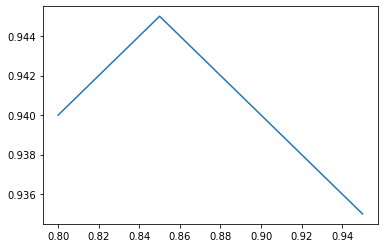

In [7]:
accuracy_for_each_alpha = []
for alpha in alphas:
    P, var, Z_train, Z_test = PCA(X_train,X_test, alpha)
    projected_Z_train = np.dot(P.T, Z_train.T)
    projected_Z_test = np.dot(P.T, Z_test.T)
    accuracy, predictions = knn(projected_Z_train,Y_train, projected_Z_test, Y_test,1)
    accuracy_for_each_alpha.append(accuracy)
    print("At alpha = " + str(alpha) + ", The mean accuracy = " + str(accuracy))
    

plt.plot(alphas, accuracy_for_each_alpha)



In [53]:
alpha_K = np.zeros((4,4)) #2-D array showing accuracy for each combination of alpha and K
for i in range(len(alphas)):
    P2, var2, Z_train2, Z_test2 = PCA(X_train,X_test, alphas[i])
    projected_Z_train2 = np.dot(P2.T, Z_train2.T)
    projected_Z_test2 = np.dot(P2.T, Z_test2.T)
    for j in range(len(k_list)):
        accuracy, predictions = knn(projected_Z_train2,Y_train, projected_Z_test2, Y_test,k_list[j])  
        alpha_K[i][j]= accuracy
        
print(alpha_K)

for alpha = 0.8 explained variance = 0.8013424991514224
for alpha = 0.85 explained variance = 0.8512997691218911
for alpha = 0.9 explained variance = 0.9001854332073947
for alpha = 0.95 explained variance = 0.9508770792642035
[[0.94  0.84  0.815 0.765]
 [0.945 0.86  0.795 0.785]
 [0.94  0.875 0.8   0.765]
 [0.935 0.885 0.785 0.775]]


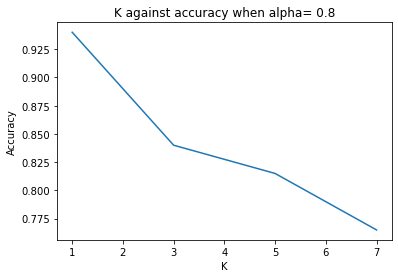

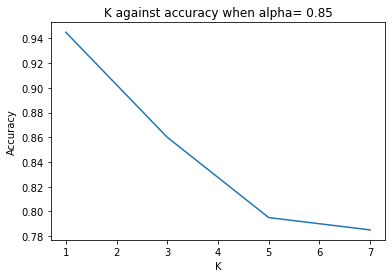

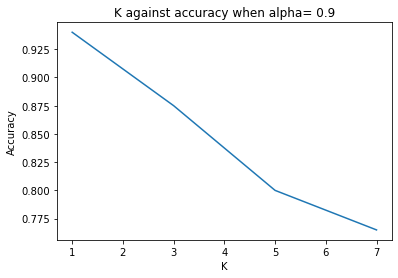

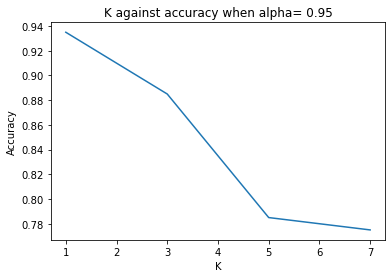

In [55]:
for i in range(len(alphas)):
    accuracies = alpha_K[i]
    plt.figure()
    plt.title("K against accuracy when alpha= " +str(alphas[i]))
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.plot(k_list,accuracies)

# LDA

### Between scatter matrix

In [9]:
def between_class_scatter(X_train, num_classes, num_samples):
    means= np.ones((num_classes,10304))
    #calculating mean of each class
    index=0
    #in case number of classes > 2
    if num_classes > 2:
        #loop over classes and compute mean for each class
        for i in range(0,X_train.shape[0],num_samples):
            means[index]=np.mean(X_train[i:i+num_samples],axis=0,keepdims=True)
            index+=1
     #in case number of classes = 2
    elif num_classes == 2:
        #compute mean for class1 and class2
        means[0]=np.mean(X_train[0:num_samples],axis=0,keepdims=True)
        means[1]=np.mean(X_train[num_samples:],axis=0,keepdims=True)
        
     #overall mean
    ov_mean=np.mean(X_train,axis=0,keepdims=True)
    Sb=np.zeros((10304,10304))
    #between class scatter
    #in case number of classes > 2
    if num_classes > 2:
        #replacing B matrix by Sb 
        for i in range(40):
            m=means[i]-ov_mean
            m=m.reshape(10304,1)
            Sb=np.add(Sb,num_samples*np.dot(m,m.T))
    #in case number of classes = 2
    elif num_classes == 2:
        #computing B matrix
        mean=means[0].reshape(10304,1)-means[1].reshape(10304,1)
        Sb=np.dot(mean,mean.T)
    return [means,Sb]

In [57]:
means,Sb=between_class_scatter(X_train,40,5)

### Within scatter matrix

In [58]:
def within_class_scatter(X_train,means, num_classes, num_samples):
    #overall mean
    ov_mean=np.mean(X_train,axis=0,keepdims=True)
    S=np.zeros((10304,10304))
    #within class scatter
    index=0
    #in case number of classes > 2
    if num_classes > 2:
        #loop over classes and compute variance for each class
        for i in range(0,X_train.shape[0],num_samples):
            class_scatter=X_train[i:i+num_samples]-means[index]
            class_scatter=class_scatter.reshape(num_samples,10304)
            index+=1
            S=np.add(S,np.dot(class_scatter.T,class_scatter))
    #in case number of classes = 2
    elif num_classes == 2 :
        #compute variance for class1 and class2
        class_scatter1=X_train[0:num_samples]-means[0]
        class_scatter2=X_train[num_classes:]-means[1]
        S1=np.dot(class_scatter1.T,class_scatter1)
        S2=np.dot(class_scatter2.T,class_scatter2)
        S=S1+S2
        
    return S

In [59]:
S=within_class_scatter(X_train,means,40,5)

### Computing eigen vectors

In [60]:
def LDA(S,Sb,num_classes):
    transformation_matrix=np.dot(np.linalg.inv(S),Sb)
    eigen_values,eigen_vectors=np.linalg.eigh(transformation_matrix)
    #sorting eigen values
    idx=np.argsort(eigen_values)[::-1]
    eigen_values=eigen_values[idx]
    eigen_vectors=eigen_vectors[:,idx]
    U=eigen_vectors[:,:num_classes-1]
    return [U,eigen_values[:num_classes-1:]]
    

In [61]:
U,E_values=LDA(S,Sb,40)


### Projecting data and KNN

In [64]:
# Centering the data
Z_train = X_train - np.mean(X_train, axis = 0) 
#centering test set
Z_test=X_test-np.mean(X_train, axis = 0)
#projecting training and test sets on U
Train_projected=np.dot(U.T,Z_train.T)
Test_projected=np.dot(U.T,Z_test.T)
#KNN
accuracy_LDA,prediction_LDA_1 = knn(Train_projected,Y_train, Test_projected, Y_test,1)
print(f"accuracy: {accuracy_LDA}")

accuracy: 0.94


### classifier tuning

accuracy: 0.94
accuracy: 0.86
accuracy: 0.815
accuracy: 0.745


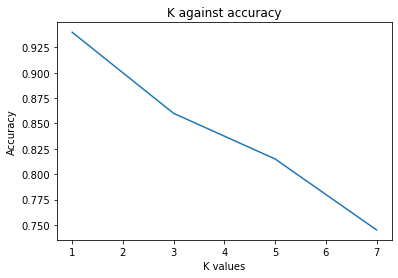

In [63]:
k_accuracies=[]
i=0
for k in k_list:
    accuracy, predictions = knn(Train_projected,Y_train, Test_projected, Y_test,k) 
    k_accuracies.append(accuracy)
    print(f"accuracy: {k_accuracies[i]}")
    i+=1
plt.figure()
plt.title("K against accuracy")
plt.xlabel("K values")
plt.ylabel("Accuracy")
plt.plot(k_list, k_accuracies)

# Compare vs Non-Face Images 

In [8]:
nonFace_data, nonFace_labels,nonFace_data_unflattened = generate_data_matrix("Nonface")
#new_data = np.concatenate((data, nonFace_data))
face_labels = np.ones((200,1))

In [9]:
def center_data(X_train,X_test):
    Z_train=X_train-np.mean(X_train, axis=0, keepdims=True)
    Z_test=X_test-np.mean(X_test, axis=0, keepdims=True)
    return [Z_train,Z_test]
    

In [10]:
def split_data(nonFace_data,nonFace_labels, X_train, Y_train, X_test, Y_test):
    X_train_nonface = nonFace_data[1::2] #odd rows for training set
    Y_train_nonface = nonFace_labels[1::2]
    X_test_nonface = nonFace_data[0::2] #even row for test set
    Y_test_nonface = nonFace_labels[0::2]
    dim = Y_train_nonface.shape[0]
    new_X_train = np.concatenate((X_train,X_train_nonface))
    new_Y_train = np.concatenate((face_labels,Y_train_nonface.reshape(dim,1)))
    new_X_test = np.concatenate((X_test,X_test_nonface))
    new_Y_test = np.concatenate((face_labels,Y_test_nonface.reshape((dim,1))))
    return [new_X_train, new_Y_train, new_X_test, new_Y_test]

In [11]:
# non_face_list = [200, 300, 400, 500, 600]
# accuracies_nonfaces = []
# # for number_of_nonfaces in non_face_list:
# #     new_X_train, new_Y_train, new_X_test, new_Y_test = split_data(nonFace_data[:number_of_nonfaces],nonFace_labels[:number_of_nonfaces], X_train, face_labels, X_test, face_labels)
# #     for alpha in alphas:
# #         P, var, Z_train, Z_test = PCA(new_X_train,new_X_test, alpha)
# #         projected_Z_train = np.dot(P.T, Z_train.T)
# #         projected_Z_test = np.dot(P.T, Z_test.T)
# #         accuracy = knn(projected_Z_train,new_Y_train, projected_Z_test, new_Y_test,1)
# #         accuracies_nonfaces.append(accuracy)

## Applying PCA for 400 face images and 400 non face images 

In [12]:
 new_X_train1,new_Y_train1, new_X_test1, new_Y_test1 = split_data(nonFace_data[:400],nonFace_labels[:400], X_train, face_labels, X_test, face_labels)

In [13]:
alpha_predictions=[]
accuracy_for_alpha=[]
for alpha in alphas:
    P, var, Z_train, Z_test = PCA(new_X_train1,new_X_test1,alpha)
    projected_train=np.dot(P.T, Z_train.T)
    projected_test = np.dot(P.T, Z_test.T)
    accuracy,predictions=knn(projected_train,new_Y_train1,projected_test,new_Y_test1,1)
    predictions=predictions.reshape(400,1)
    accuracy_for_alpha.append(accuracy)
    alpha_predictions.append(predictions)

    
    

for alpha = 0.8 explained variance = 0.8012760382250119
for alpha = 0.85 explained variance = 0.8501047863683974
for alpha = 0.9 explained variance = 0.900368833343331
for alpha = 0.95 explained variance = 0.9501695696841305


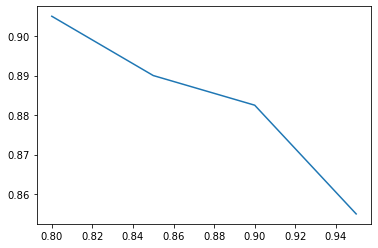

In [16]:
plt.plot(alphas,accuracy_for_alpha)

In [22]:
alpha_K_nonFaces = np.zeros((4,4)) #2-D array showing accuracy for each combination of alpha and K
for i in range(len(alphas)):
    P2, var2, Z_train2, Z_test2 = PCA(new_X_train1,new_X_test1,alphas[i])
    projected_Z_train2 = np.dot(P2.T, Z_train2.T)
    projected_Z_test2 = np.dot(P2.T, Z_test2.T)
    for j in range(len(k_list)):
        accuracy,prediction=knn(projected_Z_train2,new_Y_train1, projected_Z_test2, new_Y_test1,k_list[j]) 
        alpha_K_nonFaces[i][j]= accuracy

for alpha = 0.8 explained variance = 0.8012760382250119
for alpha = 0.85 explained variance = 0.8501047863683974
for alpha = 0.9 explained variance = 0.900368833343331
for alpha = 0.95 explained variance = 0.9501695696841305


### alpha against accuracy for different k values

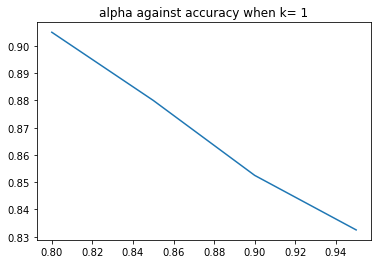

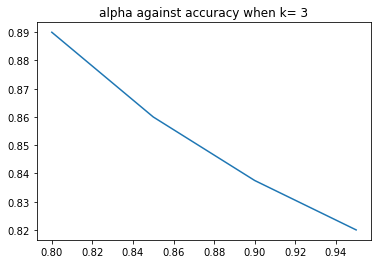

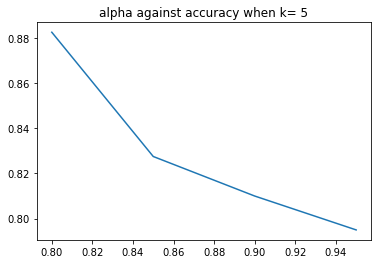

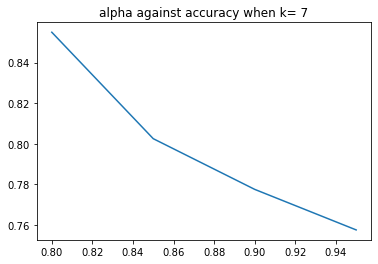

In [24]:
for i in range(len(k_list)):
    plt.figure()
    plt.title("alpha against accuracy when k= " +str(k_list[i]))
    plt.plot(alphas,alpha_K_nonFaces[i])

### Failure and success cases (PCA)
we need to add confusion matrix

Number of failure cases at alpha = 0.8 is 38
failure rate= 9.5%
Number of failure cases at alpha = 0.85 is 44
failure rate= 11.0%
Number of failure cases at alpha = 0.9 is 47
failure rate= 11.75%
Number of failure cases at alpha = 0.95 is 58
failure rate= 14.499999999999998%


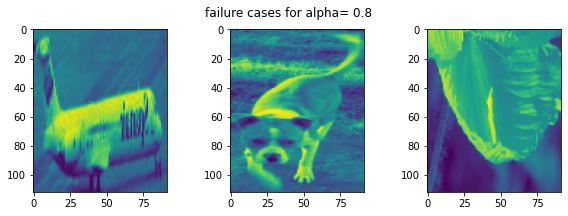

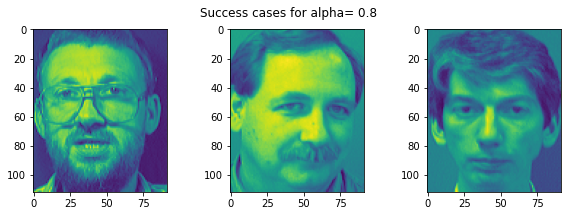

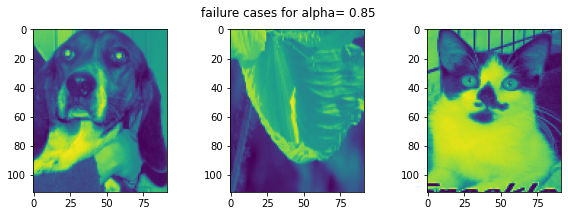

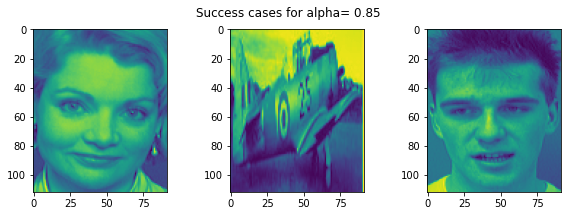

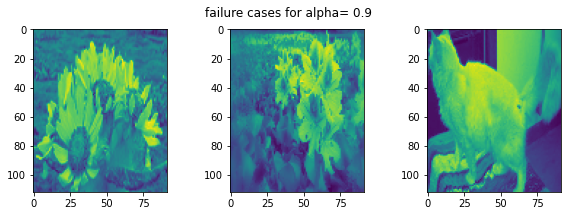

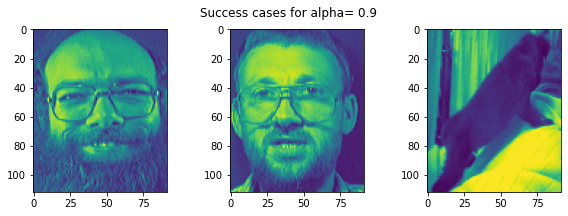

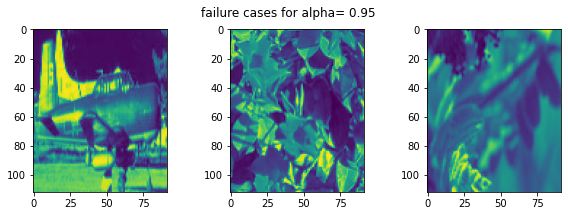

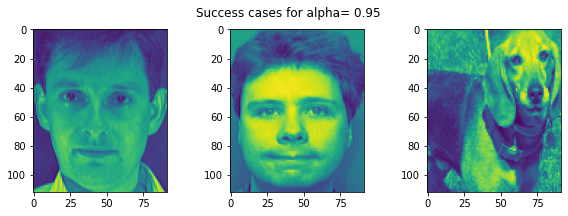

In [116]:
alpha_predictions=np.array(alpha_predictions).reshape(4,400)
for i in range(4):
    comparison=alpha_predictions[i].reshape(400,1) == new_Y_test
    index_of_false = np.array(np.where(np.any(comparison == False, axis=1)))
    index_of_true=np.array(np.where(np.any(comparison == True, axis=1)))
    num_of_false = index_of_false.shape[1]
    print("Number of failure cases at alpha = " + str(alphas[i]) + " is " + str(num_of_false))
    print("failure rate= "+str((num_of_false/400)*100)+"%")
    plt.figure(figsize=(10,3))
    for j in range(1,4):
        plt.subplot(1,3,j)
        plt.suptitle("failure cases for alpha= " + str(alphas[i]))
        index=random.choice(index_of_false[0])
        plt.imshow(new_X_test[index].reshape(112,92))
    plt.figure(figsize=(10,3))
    for j in range(1,4):
        plt.subplot(1,3,j)
        plt.suptitle("Success cases for alpha= " + str(alphas[i]))
        index=random.choice(index_of_true[0])
        plt.imshow(new_X_test[index].reshape(112,92))
      


In [13]:
P_c, var_c, Z_train_c, Z_test_c = PCA(new_X_train1,new_X_test1,0.85)
projected_train_c=np.dot(P_c.T, Z_train_c.T)
projected_test_c = np.dot(P_c.T, Z_test_c.T)
accuracy,predictions=knn(projected_train_c,new_Y_train1,projected_test_c,new_Y_test1,5)
prediction_PCA_c=predictions.reshape(400,1)


for alpha = 0.85 explained variance = 0.8501047863683975


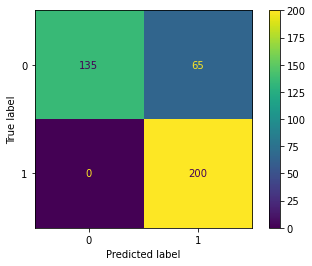

In [14]:
cm=confusion_matrix(new_Y_test1, prediction_PCA_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Applying LDA for 400 face images and 400 non face images


In [30]:
means,B=between_class_scatter(new_X_train1,2,200)

In [31]:
Ss=within_class_scatter(new_X_train1,means,2,200)

In [32]:
U,E_values=LDA(Ss,B,2)

In [34]:
#projecting 
# Centering the data
new_Z_train,new_Z_test = center_data(new_X_train1,new_X_test1)
#projecting training and test sets on U
new_Train_projected=np.dot(U.T,new_Z_train.T)
new_Test_projected=np.dot(U.T,new_Z_test.T)

In [35]:
accuracy_LDA_nonFaces,prediction_LDA = knn(new_Train_projected,new_Y_train1, new_Test_projected, new_Y_test1,1)
print(f"accuracy: {accuracy_LDA_nonFaces}")

accuracy: 0.69


### accuracy against k values

accuracy: 0.69
accuracy: 0.71
accuracy: 0.7175
accuracy: 0.74


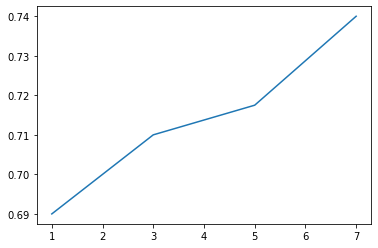

In [36]:
k_accuracies=[]
i=0
for k in k_list:
    accuracy, predictions = knn(new_Train_projected,new_Y_train1, new_Test_projected, new_Y_test1,k)
    k_accuracies.append(accuracy)
    print(f"accuracy: {k_accuracies[i]}")
    i+=1
plt.plot(k_list, k_accuracies)
    

### Failure and success cases (LDA)
we need to add confusion matrix

Number of failure cases = 124
failure rate= 31.0%


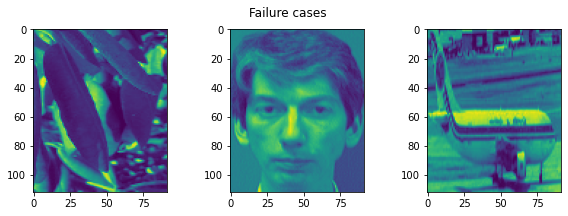

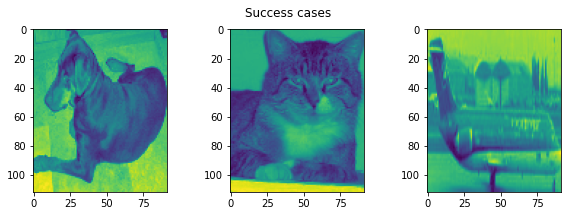

In [39]:
comparison=prediction_LDA.reshape(400,1) == new_Y_test1
index_of_false = np.array(np.where(np.any(comparison == False, axis=1)))
index_of_true=np.array(np.where(np.any(comparison == True, axis=1)))
num_of_false = index_of_false.shape[1]
print("Number of failure cases = " + str(num_of_false))
print("failure rate= "+str((num_of_false/400)*100)+"%")
plt.figure(figsize=(10,3))
for j in range(1,4):
    plt.subplot(1,3,j)
    index=random.choice(index_of_false[0])
    plt.suptitle("Failure cases")
    plt.imshow(new_X_test1[index].reshape(112,92))
plt.figure(figsize=(10,3))
for j in range(1,4):
    plt.subplot(1,3,j)
    index=random.choice(index_of_true[0])
    plt.suptitle("Success cases")
    plt.imshow(new_X_test1[index].reshape(112,92))

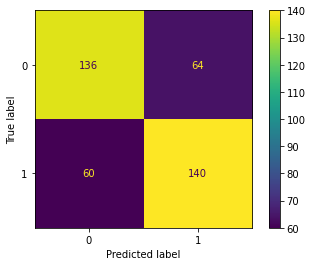

In [40]:
cm1=confusion_matrix(new_Y_test1, prediction_LDA)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()

## Fixing Number of face images while changing number of non-face images

In [13]:
non_face_list = [200, 300, 400, 500, 600]

### LDA

In [208]:

accuracies_nonfaces = []
predictions_LDA=[]
for number_of_nonfaces in non_face_list:
    new_X_train, new_Y_train, new_X_test, new_Y_test = split_data(nonFace_data[:number_of_nonfaces],nonFace_labels[:number_of_nonfaces], X_train, face_labels, X_test, face_labels)
    means,B=between_class_scatter(new_X_train,2,200)
    Ss=within_class_scatter(new_X_train,means,2,200)
    U,E_values=LDA(Ss,B,2)
    train_set,test_set=center_data(new_X_train,new_X_test)
    projected_Z_train = np.dot(U.T, train_set.T)
    projected_Z_test = np.dot(U.T, test_set.T)
    accuracy,prediction = knn(projected_Z_train,new_Y_train, projected_Z_test, new_Y_test,5)
    predictions_LDA.append(prediction)
    accuracies_nonfaces.append(accuracy)
    print(accuracy)

0.7833333333333333
0.7371428571428571
0.7175
0.6933333333333334
0.712


### Failure and success cases (LDA)

Number of failure cases when number of non-faces is 200 = 65
failure rate= 21.666666666666668%
Number of failure cases when number of non-faces is 300 = 92
failure rate= 26.285714285714285%
Number of failure cases when number of non-faces is 400 = 113
failure rate= 28.249999999999996%
Number of failure cases when number of non-faces is 500 = 138
failure rate= 30.666666666666664%
Number of failure cases when number of non-faces is 600 = 144
failure rate= 28.799999999999997%


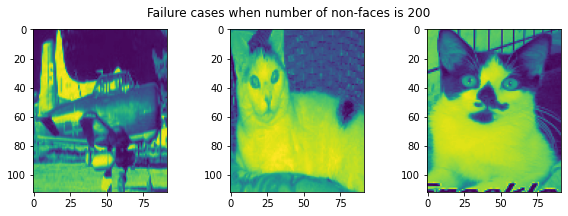

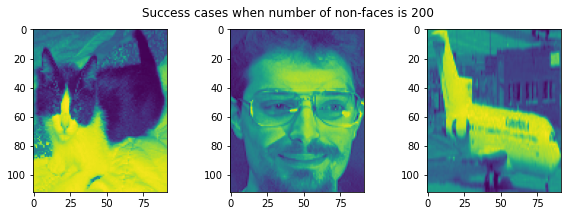

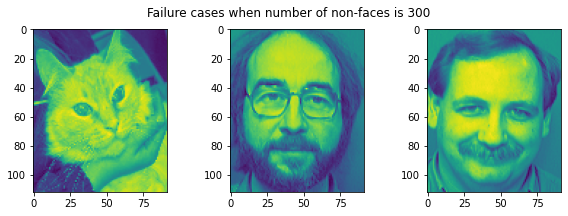

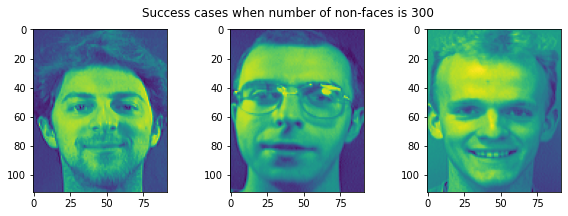

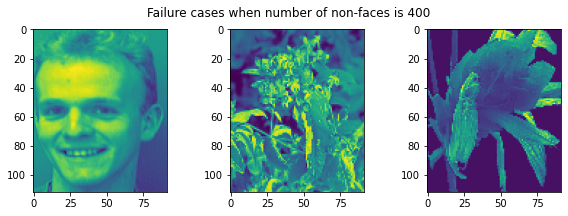

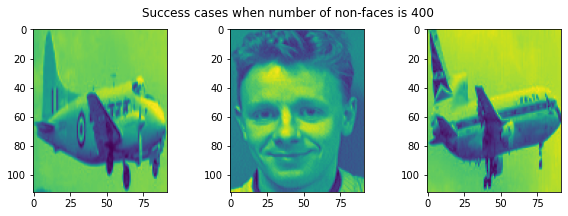

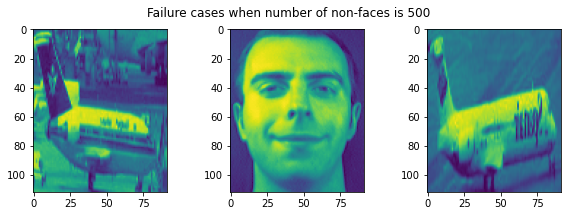

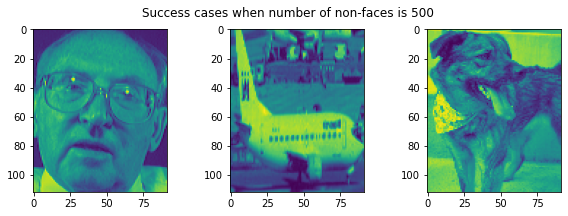

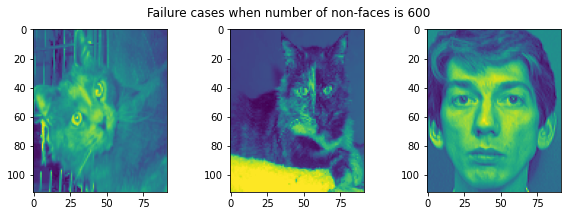

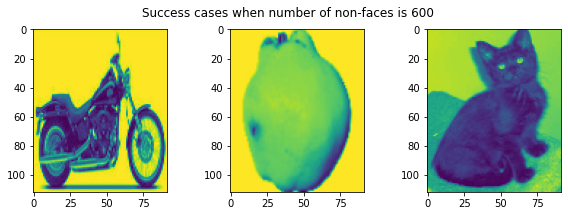

In [246]:
for i in range(5):
    new_X_train, new_Y_train, new_X_test, new_Y_test = split_data(nonFace_data[:non_face_list[i]],nonFace_labels[:non_face_list[i]], X_train, face_labels, X_test, face_labels)
    predictions_LDA[i]=np.array(predictions_LDA[i]).reshape(200+(non_face_list[i]//2),1)
    comparison=predictions_LDA[i] == new_Y_test
    index_of_false = np.array(np.where(np.any(comparison == False, axis=1)))
    index_of_true=np.array(np.where(np.any(comparison == True, axis=1)))
    num_of_false = index_of_false.shape[1]
    print("Number of failure cases when number of non-faces is "+str(non_face_list[i]) + " = " + str(num_of_false))
    print("failure rate= "+str((num_of_false/new_X_train.shape[0])*100)+"%")
    plt.figure(figsize=(10,3))
    for j in range(1,4):
        plt.subplot(1,3,j)
        index=random.choice(index_of_false[0])
        plt.suptitle("Failure cases when number of non-faces is "+str(non_face_list[i]))
        plt.imshow(new_X_test[index].reshape(112,92))
    plt.figure(figsize=(10,3))
    for j in range(1,4):
        plt.subplot(1,3,j)
        index=random.choice(index_of_true[0])
        plt.suptitle("Success cases when number of non-faces is "+str(non_face_list[i]))
        plt.imshow(new_X_test[index].reshape(112,92))


## the accuracy vs the number of non-faces images

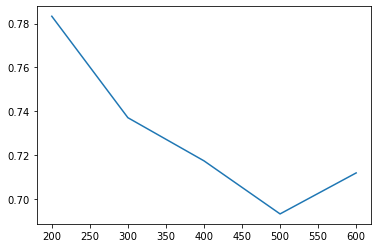

In [247]:
plt.plot(non_face_list,accuracies_nonfaces)

## PCA

In [14]:
accuracies_nonfaces_PCA = []
predictions_PCA=[]
for number_of_nonfaces in non_face_list:
    new_X_train_PCA, new_Y_train_PCA, new_X_test_PCA, new_Y_test_PCA = split_data(nonFace_data[:number_of_nonfaces],nonFace_labels[:number_of_nonfaces], X_train, face_labels, X_test, face_labels)
    Project_nonface, var, Z_train_PCA, Z_test_PCA = PCA(new_X_train_PCA, new_X_test_PCA, 0.85)
    projected_Z_train_PCA = np.dot(Project_nonface.T, Z_train_PCA.T)
    projected_Z_test_PCA = np.dot(Project_nonface.T, Z_test_PCA.T)
    accuracy,prediction = knn(projected_Z_train_PCA,new_Y_train_PCA, projected_Z_test_PCA, new_Y_test_PCA,3)
    predictions_PCA.append(prediction)
    accuracies_nonfaces_PCA.append(accuracy)
    print(accuracy)

for alpha = 0.85 explained variance = 0.851340118245401
0.87
for alpha = 0.85 explained variance = 0.851557808635064
0.8914285714285715
for alpha = 0.85 explained variance = 0.8501047863683974
0.86
for alpha = 0.85 explained variance = 0.8513187156022349
0.8866666666666667
for alpha = 0.85 explained variance = 0.8503116590049523
0.9


Number of failure cases when number of non-faces is 200 = 39
failure rate= 13.0%
Number of failure cases when number of non-faces is 300 = 38
failure rate= 10.857142857142858%
Number of failure cases when number of non-faces is 400 = 56
failure rate= 14.000000000000002%
Number of failure cases when number of non-faces is 500 = 51
failure rate= 11.333333333333332%
Number of failure cases when number of non-faces is 600 = 50
failure rate= 10.0%


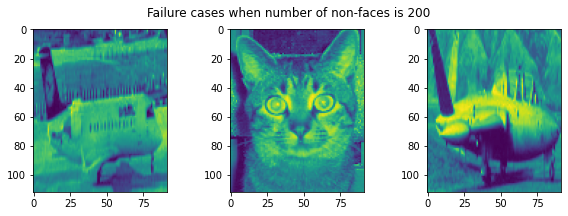

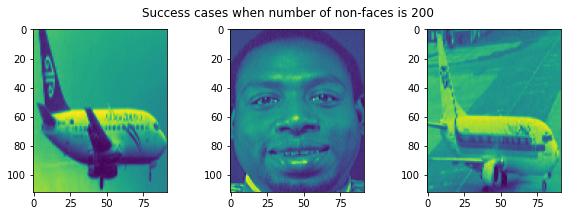

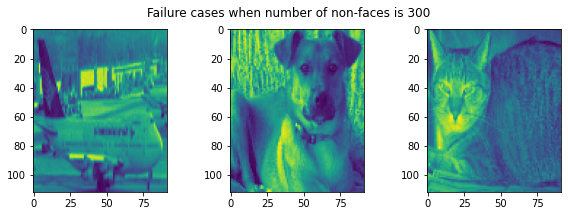

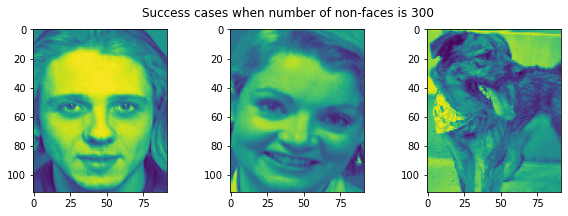

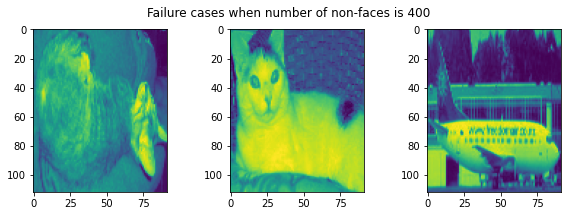

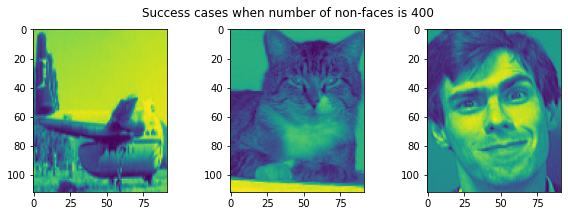

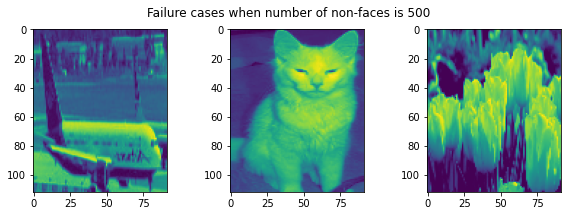

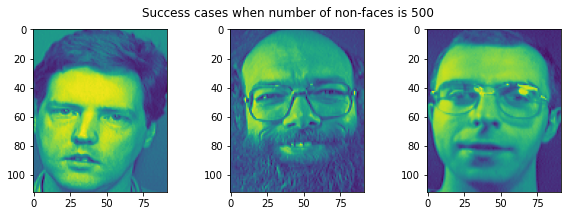

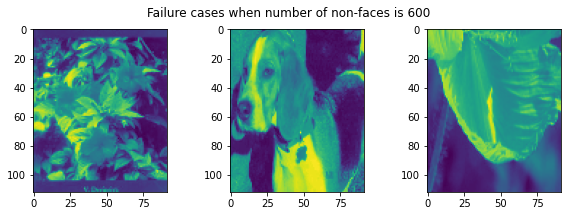

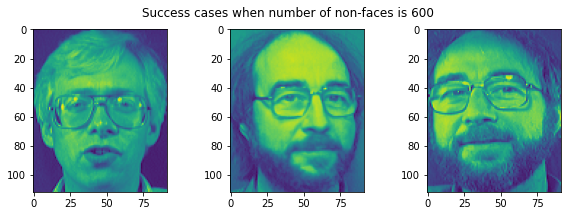

In [17]:
for i in range(5):
    new_X_train_2, new_Y_train_2, new_X_test_2, new_Y_test_2 = split_data(nonFace_data[:non_face_list[i]],nonFace_labels[:non_face_list[i]], X_train, face_labels, X_test, face_labels)
    predictions_PCA[i]=np.array(predictions_PCA[i]).reshape(200+(non_face_list[i]//2),1)
    comparison_PCA=predictions_PCA[i] == new_Y_test_2
    index_of_false = np.array(np.where(np.any(comparison_PCA == False, axis=1)))
    index_of_true=np.array(np.where(np.any(comparison_PCA == True, axis=1)))
    num_of_false = index_of_false.shape[1]
    print("Number of failure cases when number of non-faces is "+str(non_face_list[i]) + " = " + str(num_of_false))
    print("failure rate= "+str((num_of_false/new_X_train_2.shape[0])*100)+"%")
    plt.figure(figsize=(10,3))
    for j in range(1,4):
        plt.subplot(1,3,j)
        index=random.choice(index_of_false[0])
        plt.suptitle("Failure cases when number of non-faces is "+str(non_face_list[i]))
        plt.imshow(new_X_test_2[index].reshape(112,92))
    plt.figure(figsize=(10,3))
    for j in range(1,4):
        plt.subplot(1,3,j)
        index=random.choice(index_of_true[0])
        plt.suptitle("Success cases when number of non-faces is "+str(non_face_list[i]))
        plt.imshow(new_X_test_2[index].reshape(112,92))

# Bonus

### 1. Using different Training and Test splits.
Change the number of instances per subject to be 7 and keep 3 instances per subject for testing.

In [10]:
X_train_7 = []
Y_train_7 = []
X_test_7 = []
Y_test_7 = []
for i in range(0,391,10):
    X_train_7.append(data[i:i+7])
    Y_train_7.append(labels[i:i+7])
    X_test_7.append(data[i+7:i+10])
    Y_test_7.append(labels[i+7:i+10])

In [11]:
X_train_7 = np.array(X_train_7).reshape(280,10304)
Y_train_7 = np.array(Y_train_7).reshape(280,1)
X_test_7 = np.array(X_test_7).reshape(120,10304)
Y_test_7 = np.array(Y_test_7).reshape(120,1)


## PCA

In [ ]:
alpha_predictions=[]
accuracy_for_alpha=[]
for alpha in alphas:
    P_7, var_7, Z_train_7, Z_test_7 = PCA(X_train_7,X_test_7,alpha)
    projected_train_7=np.dot(P_7.T, Z_train_7.T)
    projected_test_7 = np.dot(P_7.T, Z_test_7.T)
    accuracy,predictions=knn(projected_train_7,Y_train_7,projected_test_7,Y_test_7,1)
    accuracy_for_alpha.append(accuracy)
    alpha_predictions.append(predictions)

for alpha = 0.8 explained variance = 0.8001550782410373


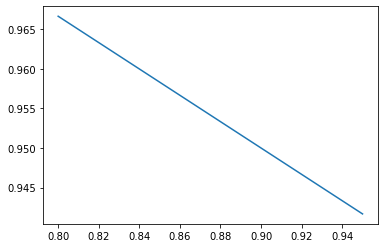

In [41]:
plt.plot(alphas,accuracy_for_alpha)

In [43]:
alpha_K_7 = np.zeros((4,4)) #2-D array showing accuracy for each combination of alpha and K
for i in range(len(alphas)):
    P7, var7, Z_train7, Z_test7 = PCA(X_train_7,X_test_7,alphas[i])
    projected_Z_train7 = np.dot(P7.T, Z_train7.T)
    projected_Z_test7 = np.dot(P7.T, Z_test7.T)
    for j in range(len(k_list)):
        accuracy,prediction=knn(projected_Z_train7,Y_train_7, projected_Z_test7, Y_test_7,k_list[j]) 
        alpha_K_7[i][j]= accuracy

for alpha = 0.8 explained variance = 0.8001311548827701
for alpha = 0.85 explained variance = 0.8505716983567252
for alpha = 0.9 explained variance = 0.9006323788277062
for alpha = 0.95 explained variance = 0.9503697497053937


In [ ]:
alpha_K_7

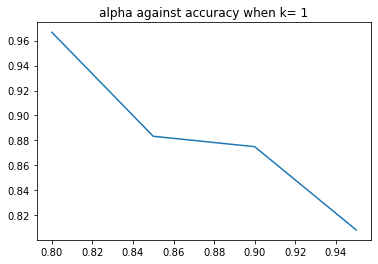

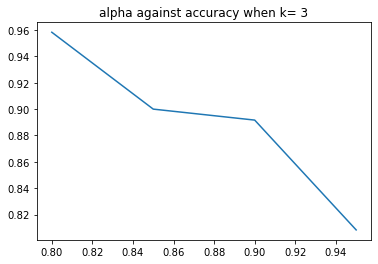

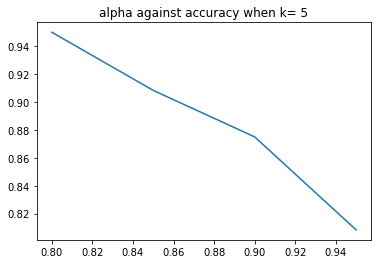

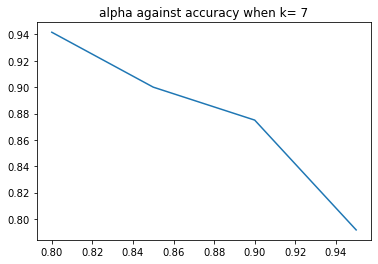

In [44]:
for i in range(len(k_list)):
    plt.figure()
    plt.title("alpha against accuracy when k= " +str(k_list[i]))
    plt.plot(alphas,alpha_K_7[i])

## LDA

In [52]:
means_7,B_7=between_class_scatter(X_train_7,40,7)

In [54]:
S_7=within_class_scatter(X_train_7,means_7,40,7)

In [55]:
U,E_values=LDA(S_7,B_7,40)

In [56]:
# Centering data
Z_train_new,Z_test_new = center_data(X_train_7,X_test_7)
#projecting training and test sets on U
Train_projected_7=np.dot(U.T,Z_train_new.T)
Test_projected_7=np.dot(U.T,Z_test_new.T)
#KNN
accuracy_LDA_7,predictions_7 = knn(Train_projected_7,Y_train_7, Test_projected_7, Y_test_7,1)
print(f"accuracy: {accuracy_LDA_7}")

accuracy: 0.95


accuracy: 0.95
accuracy: 0.8833333333333333
accuracy: 0.9
accuracy: 0.8166666666666667


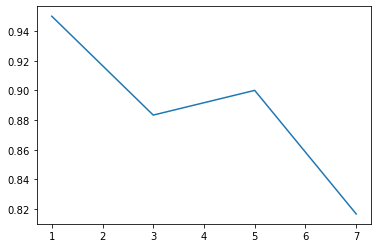

In [59]:
k_accuracies_7=[]
i=0
for k in k_list:
    accuracy, prediction = knn(Train_projected_7,Y_train_7, Test_projected_7, Y_test_7,k) 
    k_accuracies_7.append(accuracy)
    print(f"accuracy: {k_accuracies_7[i]}")
    i+=1
plt.plot(k_list, k_accuracies_7)

### 2. Trying other variations of PCA and LDA

Randomized PCA: is a variation of Principal Component Analysis (PCA) that is designed to approximate the first k principal components of a large dataset efficiently. Instead of computing the eigenvectors of the covariance matrix of the data, as is done in traditional PCA, randomized PCA uses a random projection matrix to map the data to a lower-dimensional subspace. The first k principal components of the data can then be approximated by computing the eigenvectors of the covariance matrix of the projected data.

In [24]:
n_components = [36, 52, 76, 115] # Using number of dimensions that were used when using alpha in alphas = [0.8, 0.85, 0.9, 0.95]
for n in n_components:
    randomized_pca = PCA(n_components= n,svd_solver='randomized')
    randomized_pca.fit(X_train)
    projected_train = randomized_pca.transform(X_train)
    projected_test = randomized_pca.transform(X_test)
    accuracy, predictions = knn(projected_train.T,Y_train, projected_test.T, Y_test,1)
    print(accuracy)


0.94
0.945
0.935
0.935


In [27]:
RDA=LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')

array([[230.86735511, -24.49175609,  57.01908052, ...,  -1.03934407,
         -2.42343113,  -6.90673389],
       [231.33015049, -24.47967208,  57.95675343, ...,  -0.97687072,
         -1.94741212,  -7.21343355],
       [231.46948581, -24.69329225,  57.44510367, ...,  -1.33961952,
         -2.4538751 ,  -6.96765174],
       ...,
       [208.52727551, -64.34836699, -46.89941418, ...,   7.64462705,
        -18.48203611, -10.34650157],
       [208.74242009, -64.29221121, -47.33299868, ...,   8.05641697,
        -18.37937957,  -9.59958304],
       [208.61694701, -64.63043245, -46.8038167 , ...,   7.92185482,
        -18.1509551 , -10.04545274]])

In [29]:
RDA.fit(X_train,Y_train)
RDA_train = RDA.transform(X_train)
RDA_test =RDA.transform(X_test)

In [30]:
accuracy, predictions = knn(RDA_train.T,Y_train, RDA_test.T, Y_test,1)
print(accuracy)

0.97
